In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class get_data_from_COCO(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

        self.class_names = []

        for _, class_info in self.coco.cats.items():
            self.class_names.append(class_info['name'])
        
        self.class_to_idx = dict(zip(self.class_names, range(len(self.class_names))))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        # labels = []
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            # labels.append(coco_annotation[i]['category_id'])
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        labels_tensor = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels_tensor
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [2]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

# path to your own data and coco file
train_data_dir = './datasets/train'
train_coco = './datasets/train/_annotations.coco.json'

# create own Dataset
train_data = get_data_from_COCO(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [3]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(
        dataset= train_data,
        batch_size= 8,
        shuffle= True,
        drop_last=True,
        collate_fn= collate_fn
    )

In [20]:
import torch
from torch import nn
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet50, ResNet50_Weights

from pathlib import Path
import json

device = 'cuda'

pretrain_model_path = Path('./runs/classify/train1')

with open(pretrain_model_path / 'info.json', 'r') as f:
    info_data = json.load(f)

resnet50_model = resnet50()
resnet50_model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=len(info_data['class_names']), bias=True)
)
resnet50_model.load_state_dict(torch.load(f=pretrain_model_path / 'model.pth'))
resnet50_model = resnet50_model

In [21]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
from torch import nn

# resnet50_model = resnet50(weights= ResNet50_Weights.DEFAULT)

modules = list(resnet50_model.children())[:-2]
backbone = nn.Sequential(*modules)

backbone.out_channels = 2048

In [6]:
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),),
#     aspect_ratios=((0.5, 1.0, 2.0),)
# )

# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2
# )

# faster_rcnn_model = FasterRCNN(
#     backbone,
#     num_classes=5,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# ).to(device)

In [26]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2
# num_classes = len(train_data.class_names)  # 1 class (person) + background
# get number of input features for the classifier
in_features = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
faster_rcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [8]:
from torchinfo import summary

for param in faster_rcnn_model.backbone.body.layer2.parameters():
    param.requires_grad = False

for param in faster_rcnn_model.backbone.body.layer3.parameters():
    param.requires_grad = False

for param in faster_rcnn_model.backbone.body.layer4.parameters():
    param.requires_grad = False

for param in faster_rcnn_model.backbone.fpn.parameters():
    param.requires_grad = False

for param in faster_rcnn_model.rpn.head.parameters():
    param.requires_grad = False

for param in faster_rcnn_model.roi_heads.box_head.parameters():
    param.requires_grad = False

summ = summary(model=faster_rcnn_model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
torch.cuda.empty_cache()
summ

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
FasterRCNN (FasterRCNN)                            [1, 3, 224, 224]     [100, 4]             --                   Partial
├─GeneralizedRCNNTransform (transform)             [1, 3, 224, 224]     [1, 3, 800, 800]     --                   --
├─BackboneWithFPN (backbone)                       [1, 3, 800, 800]     [1, 256, 13, 13]     --                   False
│    └─IntermediateLayerGetter (body)              [1, 3, 800, 800]     [1, 2048, 25, 25]    --                   False
│    │    └─Conv2d (conv1)                         [1, 3, 800, 800]     [1, 64, 400, 400]    (9,408)              False
│    │    └─BatchNorm2d (bn1)                      [1, 64, 400, 400]    [1, 64, 400, 400]    (128)                False
│    │    └─ReLU (relu)                            [1, 64, 400, 400]    [1, 64, 400, 400]    --                   --
│    │    └─MaxPool2d (maxpool)         

In [9]:
# # select device (whether GPU or CPU)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# # DataLoader is iterable over Dataset
# for imgs, annotations in train_dataloader:
#     imgs = list(img.to(device) for img in imgs)
#     annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
#     print(annotations)
#     print()
#     print()

# torch.cuda.empty_cache()

In [10]:
optimizer = torch.optim.SGD(params= faster_rcnn_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [11]:
num_epochs =5
len_dataloader = len(train_dataloader)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
faster_rcnn_model = faster_rcnn_model.to(device)

for epoch in range(num_epochs):
    faster_rcnn_model.train()
    i = 0    
    for imgs, annotations in train_dataloader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = faster_rcnn_model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

C:\Users\tranq\AppData\Local\miniconda3\envs\Leaf_based_project\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Iteration: 1/62, Loss: 0.6250049471855164
Iteration: 2/62, Loss: 0.6087799072265625
Iteration: 3/62, Loss: 0.5568046569824219
Iteration: 4/62, Loss: 0.5104147791862488
Iteration: 5/62, Loss: 0.43962666392326355
Iteration: 6/62, Loss: 0.3766021728515625
Iteration: 7/62, Loss: 0.3271358907222748
Iteration: 8/62, Loss: 0.2920383810997009
Iteration: 9/62, Loss: 0.27250951528549194
Iteration: 10/62, Loss: 0.2444276064634323
Iteration: 11/62, Loss: 0.23998406529426575
Iteration: 12/62, Loss: 0.2328765094280243
Iteration: 13/62, Loss: 0.24301519989967346
Iteration: 14/62, Loss: 0.20973506569862366
Iteration: 15/62, Loss: 0.2557939291000366
Iteration: 16/62, Loss: 0.20968487858772278
Iteration: 17/62, Loss: 0.20778651535511017
Iteration: 18/62, Loss: 0.21567998826503754
Iteration: 19/62, Loss: 0.2319503277540207
Iteration: 20/62, Loss: 0.20187687873840332
Iteration: 21/62, Loss: 0.2282305508852005
Iteration: 22/62, Loss: 0.2204175591468811
Iteration: 23/62, Loss: 0.20746727287769318
Iteration:

In [12]:
torch.cuda.empty_cache()

[{'boxes': tensor([[  4.9783,   9.0006, 216.5223, 203.4918],
        [104.3265,   0.9097, 221.7478, 172.0052],
        [ 19.8091,  38.1767, 143.8151, 183.5739],
        [ 39.7803,  29.8642,  61.3158,  52.7570],
        [201.2721,   0.0000, 224.0000, 193.2635],
        [160.0278,  16.5456, 223.9783, 183.6012]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7308, 0.2270, 0.0825, 0.0634, 0.0559, 0.0545], device='cuda:0')}]


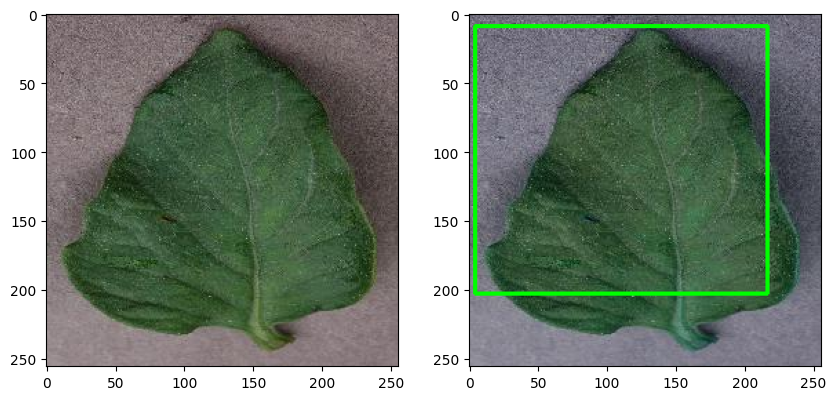

In [19]:
from torchvision import transforms
from PIL import Image
import torch 
import cv2 
import matplotlib.pyplot as plt
import glob
import random

random_img_path = random.choice(glob.glob('./datasets/train/*'))
# random_img_path = './000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG'
# random_img_path = './domla.jpg'

transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor()
    ])

# img = cv2.cvtColor(cv2.imread('./unnamed.jpg'), cv2.COLOR_BGR2RGB)
img = Image.open(random_img_path)
img_tensor = transforms_data(img)

img_tensor_in_batch = img_tensor.unsqueeze(dim= 0).to(device)

faster_rcnn_model.eval()

with torch.inference_mode():
    results = faster_rcnn_model(img_tensor_in_batch)
print(results)
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)

boxes = results[0]['boxes'].cpu().numpy()
labels = results[0]['labels'].cpu().numpy()
scores = results[0]['scores'].cpu().numpy()

score_threshold = 0.7
img = cv2.imread(random_img_path)
# Vẽ các bounding boxes và nhãn lên ảnh
for i, box in enumerate(boxes):
    if scores[i] > score_threshold:
        # Lấy tọa độ bounding box
        x1, y1, x2, y2 = box.astype(int)
        
        # Vẽ bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Vẽ nhãn và điểm số
        # label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
        score = scores[i]
        label = labels[i]

        text = f'Leaf: {score:.2f}'
        # text = f'{train_data.class_names[label]}: {score:.2f}'
        # print(train_data.class_names)
        # print(train_data.class_names[label])
        cv2.putText(img, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # break
plt.imshow(img)

In [ ]:
import torch

optimizer = torch.optim.SGD(
    params= faster_rcnn_model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [ ]:
faster_rcnn_model.train()
for imgs, annotations in train_dataloader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

faster_rcnn_model(imgs, annotations)